In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import scanpy as sc
import scvelo as scv

## Import dataframes- comparing to median vector

In [3]:
zf24 = pd.read_csv('zebrahub_24hrs_dataset/zebrahub_24hrs_cosine_sim_medianvec_May14.csv')

In [4]:
pancreas = pd.read_csv('pancreas_dataset/pancreas_cosine_sim_medianvec_May14.csv')

In [5]:
nmp = pd.read_csv('nmp_dataset/nmp_cosine_sim_medianvec_May14.csv')

In [19]:
adata_zf24 = sc.read_h5ad('zebrahub_24hrs_dataset/scVelo_deterministic_Jun22.h5ad')

In [20]:
adata_nmp = sc.read_h5ad('nmp_dataset/scVelo_deterministic_Jun22.h5ad')

In [21]:
adata_pan = sc.read_h5ad('pancreas_dataset/scVelo_deterministic_Jun22.h5ad')

### Reorganizae/Clean dataframes

In [10]:
zf24.rename(columns={'Unnamed: 0':'cell_id'}, inplace=True)

pancreas.rename(columns={'Unnamed: 0':'cell_id'}, inplace=True)

nmp.rename(columns={'Unnamed: 0':'cell_id'}, inplace=True)

In [11]:
melted_df_zf24 = zf24.melt(id_vars=['cell_id'], var_name='Method', value_name='Value')


In [12]:
melted_df_zf24['dataset'] = 'ZF embryo 24hpf'

In [13]:
melted_df_pan = pancreas.melt(id_vars=['cell_id'], var_name='Method', value_name='Value')
melted_df_pan['dataset'] = 'Pancreas'

In [14]:
melted_df_nmp = nmp.melt(id_vars=['cell_id'], var_name='Method', value_name='Value')
melted_df_nmp['dataset'] = 'ZF NMP'

In [16]:
cosine_df = pd.concat([melted_df_nmp, melted_df_pan, melted_df_zf24])
cosine_df.head()

,cell_id,Method,Value,dataset
0,TDR18_AAACCCAAGGCGAAGG-1,DeepVelo,0.789609,ZF NMP
1,TDR18_AAAGGGCAGATGACAT-1,DeepVelo,0.768176,ZF NMP
2,TDR18_AAAGGGCAGGCCCAAA-1,DeepVelo,0.838443,ZF NMP
3,TDR18_AAAGGTAAGATACGAT-1,DeepVelo,0.969117,ZF NMP
4,TDR18_AAAGGTACAGTATTCG-1,DeepVelo,0.587998,ZF NMP


In [17]:
cosine_df.groupby(['Method','dataset'])['Value'].median()

Method    dataset        
DeepVelo  Pancreas           0.894439
          ZF NMP             0.668951
          ZF embryo 24hpf    0.725817
UniTVelo  Pancreas           0.848102
          ZF NMP             0.304613
          ZF embryo 24hpf    0.391712
Velocyto  Pancreas           0.432148
          ZF NMP             0.908281
          ZF embryo 24hpf    0.922366
scv-Dyn   Pancreas           0.806421
          ZF NMP             0.837035
          ZF embryo 24hpf    0.859032
scv-Sto   Pancreas           0.862046
          ZF NMP             0.845349
          ZF embryo 24hpf    0.907386
Name: Value, dtype: float64

### Boxplot of comparison to median vector by method and dataset

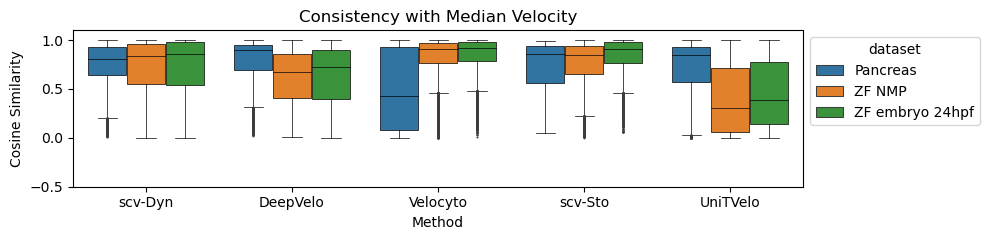

In [18]:
plt.figure(figsize=(10, 2.5))  # Adjust the figure size as per your requirements
ax = sns.boxplot(x='Method', y='Value', 
               hue='dataset',
                hue_order=['Pancreas', 'ZF NMP', 'ZF embryo 24hpf'],
               data=cosine_df, #inner='box', 
                 #palette=dataset_palette, 
                  order=['scv-Dyn', 'DeepVelo', 'Velocyto',
               'scv-Sto', 'UniTVelo'],
                 boxprops=dict(edgecolor="black", linewidth=0.5),
                 whiskerprops=dict(color="black", linewidth=0.5),
                 capprops=dict(color="black", linewidth=0.5),
                 medianprops=dict(color="black", linewidth=0.5), 
                 flierprops = dict(markerfacecolor='black', markersize=0.5,
                                   linestyle='none'))


# Add labels and title
#plt.legend()
plt.ylim(-0.5, 1.1)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('Method')
plt.ylabel('Cosine Similarity')
plt.title('Consistency with Median Velocity')

# Show the plot

plt.gcf().set_size_inches(10, 2.5)

plt.tight_layout()

#plt.savefig(save_path+'consistency_withmedianvec_perdataset.pdf')

## Combine dataframe with adata object to plot consistency with median vector

In [22]:
zf24 = zf24.set_index('cell_id')

In [23]:
nmp = nmp.set_index('cell_id')
pancreas = pancreas.set_index('cell_id')

In [25]:
adata_zf24.obs = pd.concat([adata_zf24.obs, zf24], axis=1)

In [26]:
adata_nmp.obs = pd.concat([adata_nmp.obs, nmp], axis=1)

In [27]:
adata_pan.obs = pd.concat([adata_pan.obs, pancreas], axis=1)

## Plot UMAPs colored by cosine similarity to median vector

In [28]:
def plot_velocity_embedding_streams(adata, column_list, dataset, dpi=150):
    # Number of panels based on the number of adata objects
    n_cols = len(column_list)
    fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 5), sharex=True, sharey=True, dpi=dpi)

    for i, col in enumerate(column_list):
        ax = axes[i]
        sc.pl.umap(
            adata,
            color=col,
            ax=ax, # Use the predefined axis
            color_map='cool',
            show=False,      # Prevent showing the plot immediately
            legend_fontsize=9,
            vmin=0, vmax=1,
        )
        ax.set_title('Median Cossim UMAP ' +col)  # Optionally set titles
        #ax.set_xlabel('UMAP 1')  # Set X-axis label
        #ax.set_ylabel('UMAP 2')  # Set Y-axis label
        # Rasterizing the content inside each subplot
        for child in ax.get_children():
            if isinstance(child, matplotlib.collections.Collection):
                child.set_rasterized(True)

    plt.tight_layout()
    return fig, axes

In [29]:
column_list = ['scv-Dyn', 'DeepVelo', 'Velocyto',
               'scv-Sto', 'UniTVelo']

In [30]:
save_path='/figures/agreement_comparison_plots/'

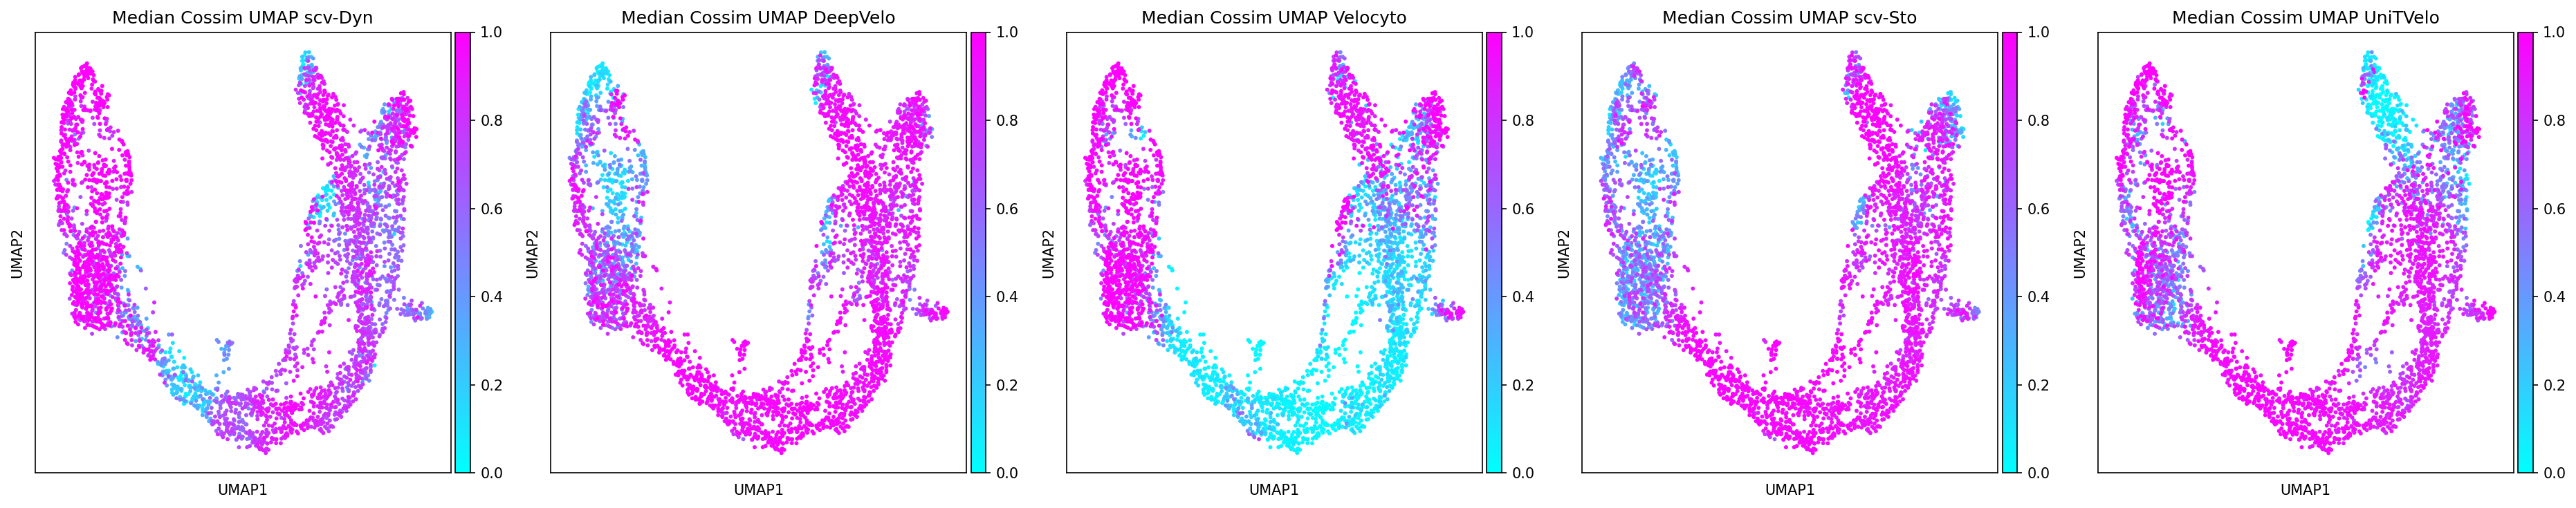

In [32]:
fig, axes = plot_velocity_embedding_streams(adata_pan, column_list, 'Pancreas')

#fig.savefig(save_path + 'pancreas_median_vec_May22.pdf', dpi=500)

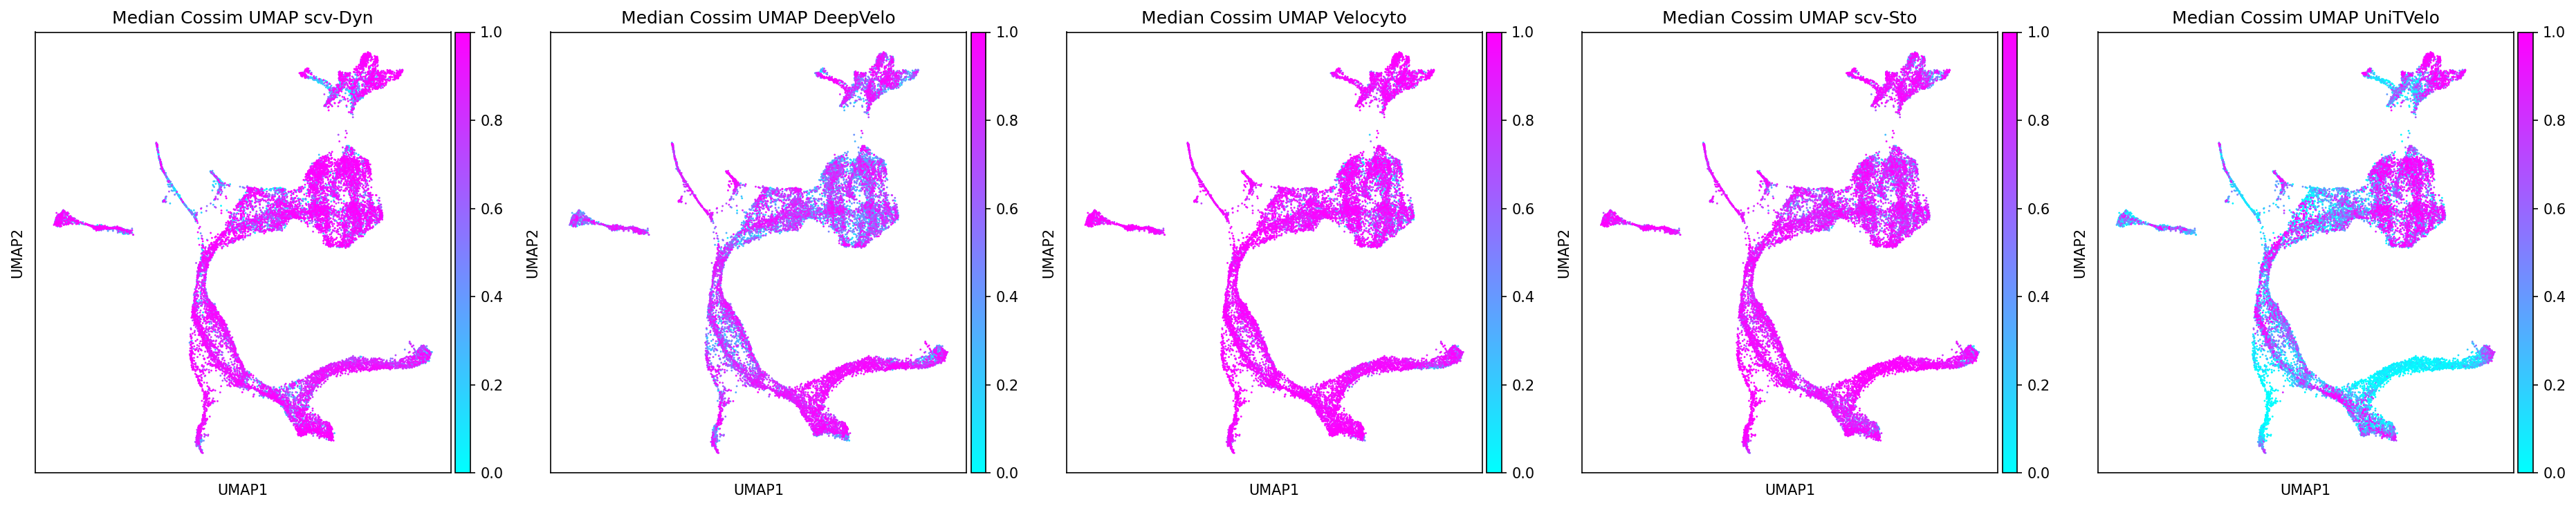

In [33]:
fig, axes = plot_velocity_embedding_streams(adata_nmp, column_list, 'ZF NMP')

#fig.savefig(save_path+'zf_nmp_median_vec_May22.pdf', dpi=500)

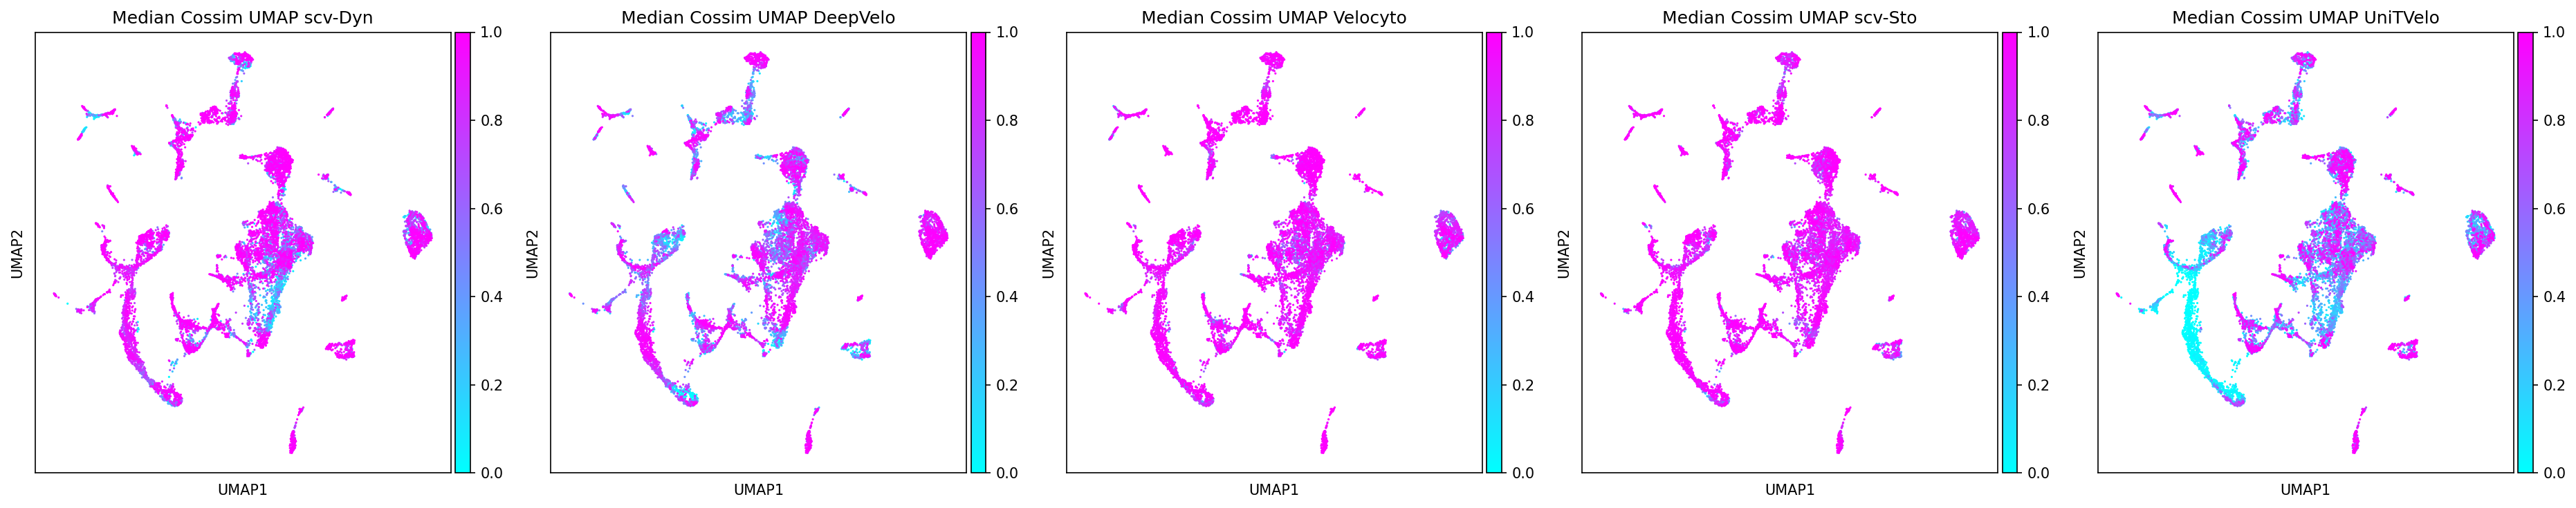

In [34]:
fig, axes = plot_velocity_embedding_streams(adata_zf24, column_list, 'ZF embryo 24hpf')

#fig.savefig(save_path+'zf_24hpf_median_vec_May22.pdf', dpi=500)